In [98]:
import pickle, sys, csv, random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
import seaborn as sns
from scipy import stats
import pandas as pd
from collections import Counter

In [44]:
# make dict from gene to list of all ages from all diff datasets
my_datasets_to_gene_to_age_dict = pickle.load(open("data/dataset_to_gene_to_age_dict.p","rb"))
gene_to_ages_list_dict = {}
my_ages_list = []
for dataset in my_datasets_to_gene_to_age_dict.keys():
    print (dataset)
    my_gene_to_age_dict = my_datasets_to_gene_to_age_dict[dataset]
    for gene in my_gene_to_age_dict.keys():
        if gene not in gene_to_ages_list_dict:
            gene_to_ages_list_dict[gene] = []
        if my_gene_to_age_dict[gene] == None:
            continue
        gene_to_ages_list_dict[gene].append(my_gene_to_age_dict[gene])
        my_ages_list.append(my_gene_to_age_dict[gene])
        

InParanoid
PANTHER8_all
PANTHER8_LDO
Orthoinspector
PhylomeDB
EnsemblCompara_v2
EggNOG
Hieranoid_2
OMA_Groups
InParanoidCore
Metaphors
OMA_Pairs
RSD


In [89]:
my_function_to_age_dict = {}
function_to_num_app_genes_dict = {}
usable_genes_list = []
function_to_genes_dict = pickle.load(open("data/function_to_genes_all_in_simplified.p","rb"))
for func in function_to_genes_dict.keys():
    if func not in my_function_to_age_dict:
        my_function_to_age_dict[func] = []
        function_to_num_app_genes_dict[func] = 0
    for gene in function_to_genes_dict[func]:
        if gene in gene_to_ages_list_dict:
            my_function_to_age_dict[func].extend(gene_to_ages_list_dict[gene])
            function_to_num_app_genes_dict[func] +=1
            usable_genes_list.append(gene)

In [79]:
def get_data_in_dataframe(function_to_ages,ages_list,function_to_num_app_genes_dict,lq = None,mq=None,uq=None):
    if lq == None:
        len_list = list(function_to_num_app_genes_dict.values())
        lq = np.percentile(len_list,25)
        mq = np.percentile(len_list,50)
        uq = np.percentile(len_list,75)
        
    data = [] #function, ages_list, mean, std, len, rand_mean, rand_std
    for func in function_to_ages:
        for my_type in ["func_grouped","random_grouped"]:
            curr = []
            ages = np.array(function_to_ages[func])
            #remove Nones
            ages = ages[ages != np.array(None)]
            if len(ages) == 0:
                continue
            if my_type == "func_grouped":
                curr.append(func)
                curr.append(ages)

                #ENTROPY
                ages_counts = dict(Counter(ages))
                age_proportions = [] # no particular order 
                for age in ages_counts.keys():
                    age_proportions.append(ages_counts[age]/len(ages))  
                my_entropy = stats.entropy(age_proportions, base=2)
                curr.append(my_entropy)       
        
            else: #random
                curr.append("no_func_name")
                ages_list = np.array(ages_list) # choosing random ages instead of choosing random genes, prob about the same result
                ages_list = ages_list[ages_list != np.array(None)]
                rand_ages = np.array(random.sample(list(ages_list),len(ages)))
                curr.append(rand_ages)
                
                # ENTROPY
                rand_ages_counts = Counter(rand_ages)
                rand_age_proportions = [] # no particular order 
                for rand_age in rand_ages_counts.keys():
                    rand_age_proportions.append(rand_ages_counts[rand_age]/len(rand_ages))
                my_rand_entropy = stats.entropy(rand_age_proportions, base=2)
                curr.append(my_rand_entropy) 
 

            #NUM ELS and TYPE
            curr.append(len(ages))
            curr.append(my_type)
            
            # GENE SET
            if function_to_num_app_genes_dict[func] < lq:
                curr.append("Less Than %d Genes"%lq)
            elif function_to_num_app_genes_dict[func] < mq:
                curr.append("Less Than %d Genes"%mq)
            elif function_to_num_app_genes_dict[func] < uq:
                curr.append("Less Than %d Genes"%uq)
            else:
                curr.append("Largest Gene Sets")
            data.append(curr)
    
    print (data)
    df = pd.DataFrame(data)
    df.columns = ['function_name','ages_list',
                  'Entropy','num_els','Type','GeneSet']
    return df

In [80]:
df = get_data_in_dataframe(my_function_to_age_dict,my_ages_list,function_to_num_app_genes_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



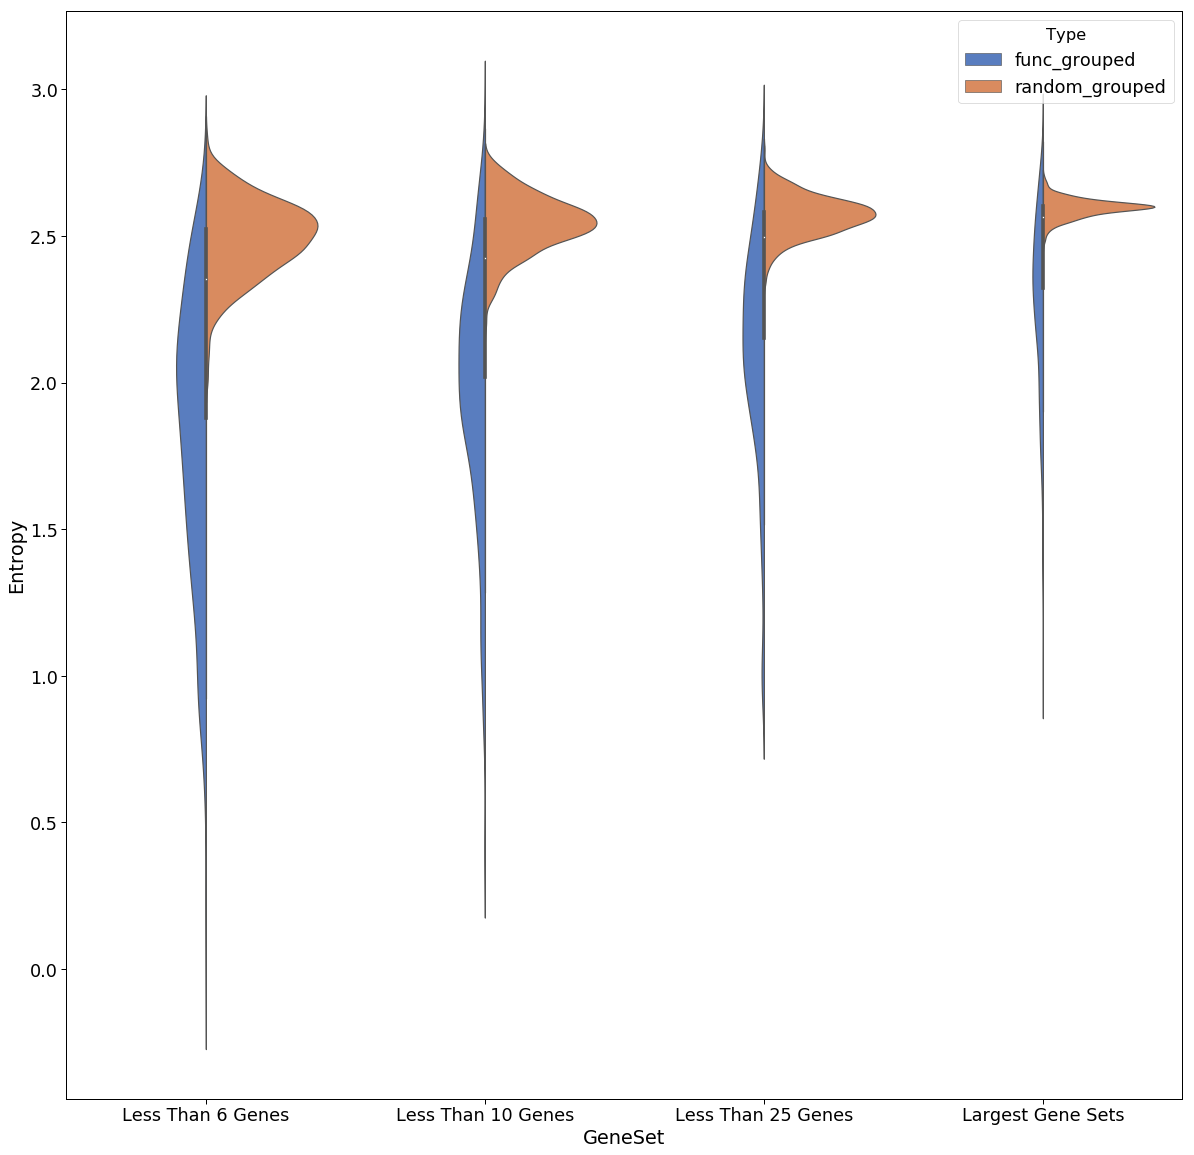

In [83]:
# make violin plot for entropy distribution of function grouped genes vs random grouped genes
len_list = list(function_to_num_app_genes_dict.values())
lq = np.percentile(len_list,25)
mq = np.percentile(len_list,50)
uq = np.percentile(len_list,75)
        
v_df = df[["GeneSet","Entropy", "Type"]]
sns.set_context("paper",font_scale = 2)
ax = sns.violinplot(x="GeneSet",y="Entropy",data=v_df,order = ["Less Than %d Genes"%lq,"Less Than %d Genes"%mq ,"Less Than %d Genes"%uq,"Largest Gene Sets"],hue="Type",palette="muted",split=True)
plt.savefig("figures/violinplot_of_entropy_among_all_datasets_rep_in_group_quartiles.png",dpi=600)
plt.show()

In [87]:
# make z score chart
# X axis, number of genes in function
# Y axis, Z score of comparing whether entropy of function grouped genes is different than that of 
# 100 random grouped genes of the same group size
func_and_entropy_list = df[df["Type"]=="func_grouped"][['Entropy','function_name']].values.tolist()

In [101]:
flatten = lambda l: [item for sublist in l for item in sublist]
num_genes_and_zscore_list = []
num_genes_to_random_grouped_entropies_mean_std_dict = {}
for entropy,func in func_and_entropy_list:
    num_genes = function_to_num_app_genes_dict[func]
    print (num_genes, entropy, func)
    if  num_genes in num_genes_to_random_grouped_entropies_mean_std_dict :
        mymean,mystd  = num_genes_to_random_grouped_entropies_mean_std_dict [num_genes]
    else:
        random_grouped_entropies_list = []
        for i in range(0,100):
            rand_genes = np.array(random.sample(usable_genes_list,num_genes))
            rand_ages = flatten([gene_to_ages_list_dict[rand_gene] for rand_gene in rand_genes])
            rand_ages_props = [num_of_rand_age/len(rand_ages) for num_of_rand_age in Counter(rand_ages).values()]
            random_grouped_entropies_list.append(stats.entropy(rand_ages_props, base=2))
            
        mystd = np.std(random_grouped_entropies_list)
        mymean = np.mean(random_grouped_entropies_list)
        num_genes_to_random_grouped_entropies_mean_std_dict[num_genes] = [mymean,mystd]

    zscore = (entropy-mymean)/(mystd)
    num_genes_and_zscore_list.append([num_genes,zscore])

18 2.140867470767152 GO:0071300~cellular response to retinoic acid
6 1.7142140946408857 IPR001064:Beta/gamma crystallin
6 2.6221154742837087 GO:0031404~chloride ion binding
9 2.0836202948214773 zinc finger region:C2H2-type 21
13 1.8884214425704977 GO:0018149~peptide cross-linking
3 2.5539701754876747 domain:Roc
4 1.7585874746807553 binding site:Alpha-ketoglutarate
6 1.9672962662654137 domain:PAS
10 1.8734694154345832 zinc finger region:C2H2-type 4; degenerate
8 2.3437278599753895 metal ion-binding site:Manganese 1
12 1.8038995383126304 IPR002957:Keratin, type I
74 2.2115829935880007 calcium-binding region:2
3 1.0966631080987514 PIRSF038886:pellino
5 1.77751517470686 domain:MATH
8 1.7873946444762052 domain:PI-PLC Y-box
23 2.132046637001452 lipid moiety-binding region:S-geranylgeranyl cysteine
5 2.2250015255340267 GO:0019531~oxalate transmembrane transporter activity
14 2.0747119665444993 repeat:TPR 7
4 2.2435890238763787 GO:0047499~calcium-independent phospholipase A2 activity
68 2.2572

10 1.9008218678162414 GO:0051219~phosphoprotein binding
24 2.209079820524001 SM00449:SPRY
80 1.8131607316107325 domain:Ig-like C2-type 2
8 2.1443206180312346 repeat:Spectrin 3
13 2.395936579106862 Myosin
19 1.935504771229507 GO:0005604~basement membrane
3 0.9389977315718142 IPR019770:Eukaryotic translation initiation factor 4E (eIF-4E), conserved site
5 2.1578529637366044 GO:0010226~response to lithium ion
14 1.7587098231092673 IPR020849:Small GTPase superfamily, Ras type
5 1.146041548414 SM00310:PTBI
397 2.4043406664360587 Immunity
11 2.654107018066856 metal ion-binding site:Magnesium 2
68 2.5051640237509294 hsa04910:Insulin signaling pathway
20 1.731245517419146 GO:0051216~cartilage development
30 2.307936263663209 GO:0031901~early endosome membrane
7 1.6624062703312759 GO:0016338~calcium-independent cell-cell adhesion via plasma membrane cell-adhesion molecules
56 2.6795982782967926 Heme
8 2.3780450704369747 Phagocytosis
80 2.4689661496557394 Manganese
9 2.2632572366031636 GO:006007

4 2.1482789224830863 repeat:WD 15
4 1.1759545428254792 PIRSF038193:hyaluronidase
9 1.9836584407972364 Threonine protease
4 1.8690746665964333 repeat:Gelsolin-like 4
18 2.429015421621049 GO:0005811~lipid particle
8 2.698652191386334 GO:0006796~phosphate-containing compound metabolic process
66 1.890929973745371 IPR020894:Cadherin conserved site
10 2.066763600459785 GO:0051017~actin filament bundle assembly
10 2.553815715602051 GO:0019369~arachidonic acid metabolic process
3 2.017907850722807 GO:0004052~arachidonate 12-lipoxygenase activity
8 2.3076658173357445 GO:0006691~leukotriene metabolic process
4 1.6404509589340972 GO:0015245~fatty acid transporter activity
8 2.6027858094676537 domain:CBS 1
112 2.5293733325336354 Protease inhibitor
12 2.546882538976639 IPR015424:Pyridoxal phosphate-dependent transferase
4 1.8794956140491201 GO:0015277~kainate selective glutamate receptor activity
8 2.105024334330245 h_g2Pathway:Cell Cycle: G2/M Checkpoint
48 2.317639319848882 GO:0008289~lipid bind

4 1.503181597525397 GO:0014037~Schwann cell differentiation
5 1.5097059596624776 IPR001263:Phosphoinositide 3-kinase, accessory (PIK) domain
9 2.146517685401468 zinc finger region:Phorbol-ester/DAG-type 1
22 1.5635941399234923 GO:0007200~phospholipase C-activating G-protein coupled receptor signaling pathway
22 2.026576131604994 GO:0046854~phosphatidylinositol phosphorylation
9 2.457019422400722 GO:0030507~spectrin binding
199 1.3847335162191448 GO:0004984~olfactory receptor activity
10 2.1934156252358648 GO:0010906~regulation of glucose metabolic process
13 1.7675658779064027 hsa03022:Basal transcription factors
5 2.3944365110325694 SM00557:IG_FLMN
4 2.3729880723437335 region of interest:4 X approximate repeats
15 2.5054342138045254 IPR018303:P-type ATPase, phosphorylation site
15 2.192792066376003 GO:0050853~B cell receptor signaling pathway
4 2.256990678057737 region of interest:Triple-helical region 2 (COL2)
9 1.3827931474989046 zinc finger region:DHHC-type
14 1.802354454192351 IPR

8 1.8455734971726632 Viral nucleoprotein
68 2.4697236272906444 hsa04921:Oxytocin signaling pathway
33 1.8429955292402291 domain:Fibronectin type-III 1
15 2.2222207210384277 SM00271:DnaJ
13 2.043017693767726 Notch signaling pathway
3 2.179418067808644 GO:0090324~negative regulation of oxidative phosphorylation
4 2.400632040820235 GO:0002485~antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway, TAP-dependent
6 1.823813773360178 GO:0008188~neuropeptide receptor activity
8 1.7873946444762052 IPR001711:Phospholipase C, phosphatidylinositol-specific, Y domain
6 2.3110566665728918 domain:CNH
16 2.291864062502004 GO:0043195~terminal bouton
26 2.2382813407582303 GO:0035335~peptidyl-tyrosine dephosphorylation
10 2.1209131741674367 IPR023578:Ras guanine nucleotide exchange factor, domain
8 2.7353881106050713 IPR002403:Cytochrome P450, E-class, group IV
3 1.3724294543080713 IPR000406:RHO protein GDP dissociation inhibitor
4 1.9302050372472639 IPR004147:U

4 0.6343095546405662 IPR000532:Glucagon/GIP/secretin/VIP
11 2.1209430723887324 GO:0008219~cell death
4 1.7926483502303352 GO:0060982~coronary artery morphogenesis
4 2.2883883076852443 SM00592:BRK
6 1.9450947394261764 domain:EGF-like 13; calcium-binding
5 0.9680134322563785 GO:0046703~natural killer cell lectin-like receptor binding
9 2.1910432484471447 IPR001173:Glycosyl transferase, family 2
4 1.7563223739105327 GO:0005168~neurotrophin TRKA receptor binding
46 2.265877256370648 hsa04750:Inflammatory mediator regulation of TRP channels
8 2.000465839234784 short sequence motif:HXXXXD motif
13 2.3306479557943813 domain:GST C-terminal
13 1.813646699866664 PIRSF002419:tetraspanin
19 2.3584308099375564 GO:0005903~brush border
8 1.8570092718739413 SM00079:PBPe
11 2.290831518061197 IPR017892:Protein kinase, C-terminal
6 2.113861326959388 GO:0008239~dipeptidyl-peptidase activity
3 2.511394303039014 domain:P-type 2
4 1.8484362384794193 domain:CobW C-terminal
3 2.3034358760802633 GO:0060166~olfa

8 2.3219015145280073 GO:0007214~gamma-aminobutyric acid signaling pathway
22 2.115225021507715 GO:0032355~response to estradiol
48 2.3982270956428793 repeat:LRR 4
42 2.1644243169742894 Heparin-binding
6 1.1691446638640766 region of interest:Alpha-3
139 2.2985407677224456 GO:0000122~negative regulation of transcription from RNA polymerase II promoter
6 2.3175990153060204 GO:0016702~oxidoreductase activity, acting on single donors with incorporation of molecular oxygen, incorporation of two atoms of oxygen
34 1.939594452785842 domain:C2 1
6 1.7472610471902597 GO:0051764~actin crosslink formation
5 2.6640736095778106 GO:0015101~organic cation transmembrane transporter activity
7 2.502509516152831 GO:0030431~sleep
4 1.8168194713671397 IPR010507:Zinc finger, MYM-type
5 2.478869273109803 GO:0016798~hydrolase activity, acting on glycosyl bonds
15 2.423582204333114 h_PparaPathway:Mechanism of Gene Regulation by Peroxisome Proliferators via PPARa(alpha)
51 2.442574101723964 IPR005821:Ion transp

158 2.346825928847285 GO:0004672~protein kinase activity
3 1.534420037390336 IPR022158:Inositol phosphatase
7 1.8300257102604 GO:0051123~RNA polymerase II transcriptional preinitiation complex assembly
7 2.2220415771727886 GO:0045088~regulation of innate immune response
4 2.037281945164636 GO:1900042~positive regulation of interleukin-2 secretion
19 1.939225310148381 hsa05140:Leishmaniasis
6 1.9929924576373406 GO:1900119~positive regulation of execution phase of apoptosis
60 2.404664133634268 GO:0098641~cadherin binding involved in cell-cell adhesion
4 2.023648963495637 IPR008598:Drought induced 19/ RING finger protein 114
9 2.4448058380121895 IPR003960:ATPase, AAA-type, conserved site
20 2.537571845516667 hsa04978:Mineral absorption
6 1.8461278371585692 GO:0043560~insulin receptor substrate binding
13 2.397025320191556 GO:0016746~transferase activity, transferring acyl groups
5 2.1905944505504835 nucleotide phosphate-binding region:cAMP
97 2.117370865515626 GO:0006955~immune response


8 1.5595783199954576 GO:0004950~chemokine receptor activity
7 1.1981070125913353 domain:NTR
5 2.2250015255340267 GO:0008271~secondary active sulfate transmembrane transporter activity
11 1.953338582870186 IPR008996:Cytokine, IL-1-like
12 0.9940302114769566 GO:0042100~B cell proliferation
6 2.2804430556572126 GO:0032469~endoplasmic reticulum calcium ion homeostasis
8 1.6677861560825953 IPR001827:Homeobox protein, antennapedia type, conserved site
3 1.7470731093603922 GO:0014051~gamma-aminobutyric acid secretion
4 2.370905865731362 IPR001223:Glycoside hydrolase, family 18, catalytic domain
13 1.7075364032584255 domain:Collagen-like
16 1.797211472942957 GO:0000502~proteasome complex
7 1.0478821099846942 IPR019570:Gap junction protein, cysteine-rich domain
59 2.139735898694522 GO:0031625~ubiquitin protein ligase binding
40 2.682975550335381 hsa00980:Metabolism of xenobiotics by cytochrome P450
6 2.0490016180916957 GO:0035909~aorta morphogenesis
12 2.182694670199813 short sequence motif:DEA

205 1.7402135284614204 SM00349:KRAB
9 1.80156811446423 IPR002165:Plexin
26 2.0784841956324285 IPR008160:Collagen triple helix repeat
15 2.2400932052724225 domain:RRM 3
17 2.435705459125333 GO:0005249~voltage-gated potassium channel activity
40 2.3804184307015968 compositionally biased region:Poly-Lys
7 2.498020596033181 IPR023298:P-type ATPase,  transmembrane domain
8 1.3006500443606617 GO:0030117~membrane coat
25 2.3569024833534606 GO:0002020~protease binding
148 2.6280103150049094 GO:0034220~ion transmembrane transport
5 2.3032229932428216 domain:Leucine-zipper 2
10 2.7104759671404666 GO:0044341~sodium-dependent phosphate transport
24 2.3420767775993627 hsa04972:Pancreatic secretion
3 0.7793498372920851 IPR000040:Acute myeloid leukemia 1 protein (AML1)/Runt
1134 2.4699495594715346 GO:0005887~integral component of plasma membrane
20 2.538968301311124 GO:0008544~epidermis development
4 0.9403058364739683 PIRSF005992:adaptor protein complex, mu subunit
22 2.3198587538118707 IPR000961:AG

8 1.8570092718739413 IPR001508:NMDA receptor
7467 2.6082781563195954 Polymorphism
9 2.2918234959104646 Amyloidosis
13 2.054778715811918 GO:0034613~cellular protein localization
509 2.6728169588001918 IPR027417:P-loop containing nucleoside triphosphate hydrolase
88 2.7032119430455817 Microsome
10 1.7474793899238326 GO:0002040~sprouting angiogenesis
5 1.8190269457641055 domain:TB 1
3 1.7002237262558648 GO:0060005~vestibular reflex
4 1.8168194713671397 zinc finger region:MYM-type 2
34 2.6073828021011995 GO:0007568~aging
13 2.225100031286071 IPR000340:Dual specificity phosphatase, catalytic domain
15 1.838736172120972 IPR002870:Peptidase M12B, propeptide
7 1.7985755172922548 h_cardiacEGFPathway:Role of EGF Receptor Transactivation by GPCRs in Cardiac Hypertrophy
31 2.2338647983758846 domain:RRM 2
4 1.5988221891639007 domain:VWFD 4
12 2.245394830289463 Redox-active center
17 1.8939166831457281 active site:Glycyl thioester intermediate
15 2.2400746152455846 GO:0001725~stress fiber
725 2.5921

60 1.9952996603045212 GO:0007166~cell surface receptor signaling pathway
7 1.8825046826962175 IPR001936:Ras GTPase-activating protein
15 2.0722511873666067 hsa05416:Viral myocarditis
84 2.226005596560067 lipid moiety-binding region:S-palmitoyl cysteine
88 2.3161678931084713 IPR009003:Trypsin-like cysteine/serine peptidase domain
41 2.024733983509793 IPR001664:Intermediate filament protein
91 2.1097957900178135 IPR000742:Epidermal growth factor-like domain
18 1.5194207316745962 IPR023395:Mitochondrial carrier domain
5 1.9961228184689546 domain:EGF-like 18; calcium-binding
14 2.591398249888537 GO:0014070~response to organic cyclic compound
4 2.338937600762737 metal ion-binding site:Calcium 4; via carbonyl oxygen
4 2.1045059925591043 IPR000239:GPCR kinase
6 2.1836164322364313 GO:0061158~3'-UTR-mediated mRNA destabilization
557 2.4164889585499973 GO:0006355~regulation of transcription, DNA-templated
13 2.039255283416729 SM00192:LDLa
4 2.5302708111182346 repeat:35
41 2.38927057234076 GO:000

7 2.0572419795714016 GO:0070382~exocytic vesicle
4 1.731917821836278 GO:0042719~mitochondrial intermembrane space protein transporter complex
12 1.274154414196788 IPR013273:Peptidase M12B, ADAM-TS
74 2.5593642383849184 GO:0072562~blood microparticle
5 1.7846263309738202 domain:EGF-like 17
37 1.9562537251948726 SM00060:FN3
6 1.899825420405262 repeat:LDL-receptor class B 4
5 2.0039333167873954 GO:0010820~positive regulation of T cell chemotaxis
23 2.222916964157378 GO:0008021~synaptic vesicle
7 1.5547937189049912 IPR000403:Phosphatidylinositol 3-/4-kinase, catalytic domain
4 1.6475061076653337 GO:0045606~positive regulation of epidermal cell differentiation
6 2.445167101675169 GO:0046323~glucose import
5 2.448863722325967 short sequence motif:Selectivity filter part_1
6 2.008569617728027 GO:0005227~calcium activated cation channel activity
21 2.2550043784437444 GO:0007265~Ras protein signal transduction
13 0.9972191807836899 IPR012351:Four-helical cytokine, core
19 1.463006558978059 IPR0

103 2.1125558548780767 GO:0007411~axon guidance
8 2.6027858094676537 IPR000644:Cystathionine beta-synthase, core
42 2.5528665124829066 GO:0042981~regulation of apoptotic process
7 1.999475661156786 domain:Laminin N-terminal
12 2.3347710247201525 SM00093:SERPIN
87 2.693840720359216 active site:Proton donor
6 1.9625519901890838 domain:EGF-like 16; calcium-binding
7 2.711886386833907 GO:0042573~retinoic acid metabolic process
20 2.126114707185752 Tight junction
11 2.5988259273986944 GO:0071377~cellular response to glucagon stimulus
81 2.3538524154586518 IPR000210:BTB/POZ-like
21 1.8899922732342693 domain:Fibronectin type-III 3
4 1.6041578571855395 IPR003121:SWIB/MDM2 domain
152 2.3392182914404462 GO:0005783~endoplasmic reticulum
7 2.727340805467052 GO:0008210~estrogen metabolic process
8 2.3827115721891525 IPR000585:Hemopexin-like domain
22 2.21315305044725 hsa04540:Gap junction
6 2.188311091102532 GO:0002009~morphogenesis of an epithelium
17 2.3773270708445158 short sequence motif:Select

6 1.5351617862489249 glycosylation site:O-linked (Xyl...) (glycosaminoglycan)
8 2.112363796762459 domain:Fe2OG dioxygenase
22 2.2187957578327624 GO:0060071~Wnt signaling pathway, planar cell polarity pathway
54 1.782129303587125 GO:0006886~intracellular protein transport
28 2.4401345868269524 hsa04725:Cholinergic synapse
87 2.351164662379462 Cytoplasmic vesicle
43 2.076183817046816 zinc finger region:C2H2-type 19
44 1.9797372148912695 GO:0005667~transcription factor complex
3 2.024155713842418 GO:0032920~putrescine acetylation
8 1.8419573353451748 IPR017979:GPCR, family 3, conserved site
84 2.303751031734993 Protein phosphatase
6 2.1971532769237023 GO:0006198~cAMP catabolic process
24 2.455425348325606 GO:0042470~melanosome
3 2.350902937480853 GO:0008900~hydrogen:potassium-exchanging ATPase activity
9 2.4474460571829355 GO:0030007~cellular potassium ion homeostasis
4 1.1759545428254792 IPR018155:Hyaluronidase
9 1.871529510760304 IPR006586:ADAM, cysteine-rich
19 2.69624775435278 GO:0006

15 2.3082056713719585 GO:0007254~JNK cascade
36 2.6072253963982064 hsa00982:Drug metabolism - cytochrome P450
23 1.391810205925235 ER-Golgi transport
17 0.9975684044918361 IPR001723:Steroid hormone receptor
12 2.581715253941582 GO:0044255~cellular lipid metabolic process
13 2.0395109861229392 GO:0006911~phagocytosis, engulfment
4 1.4745271827779922 GO:0043567~regulation of insulin-like growth factor receptor signaling pathway


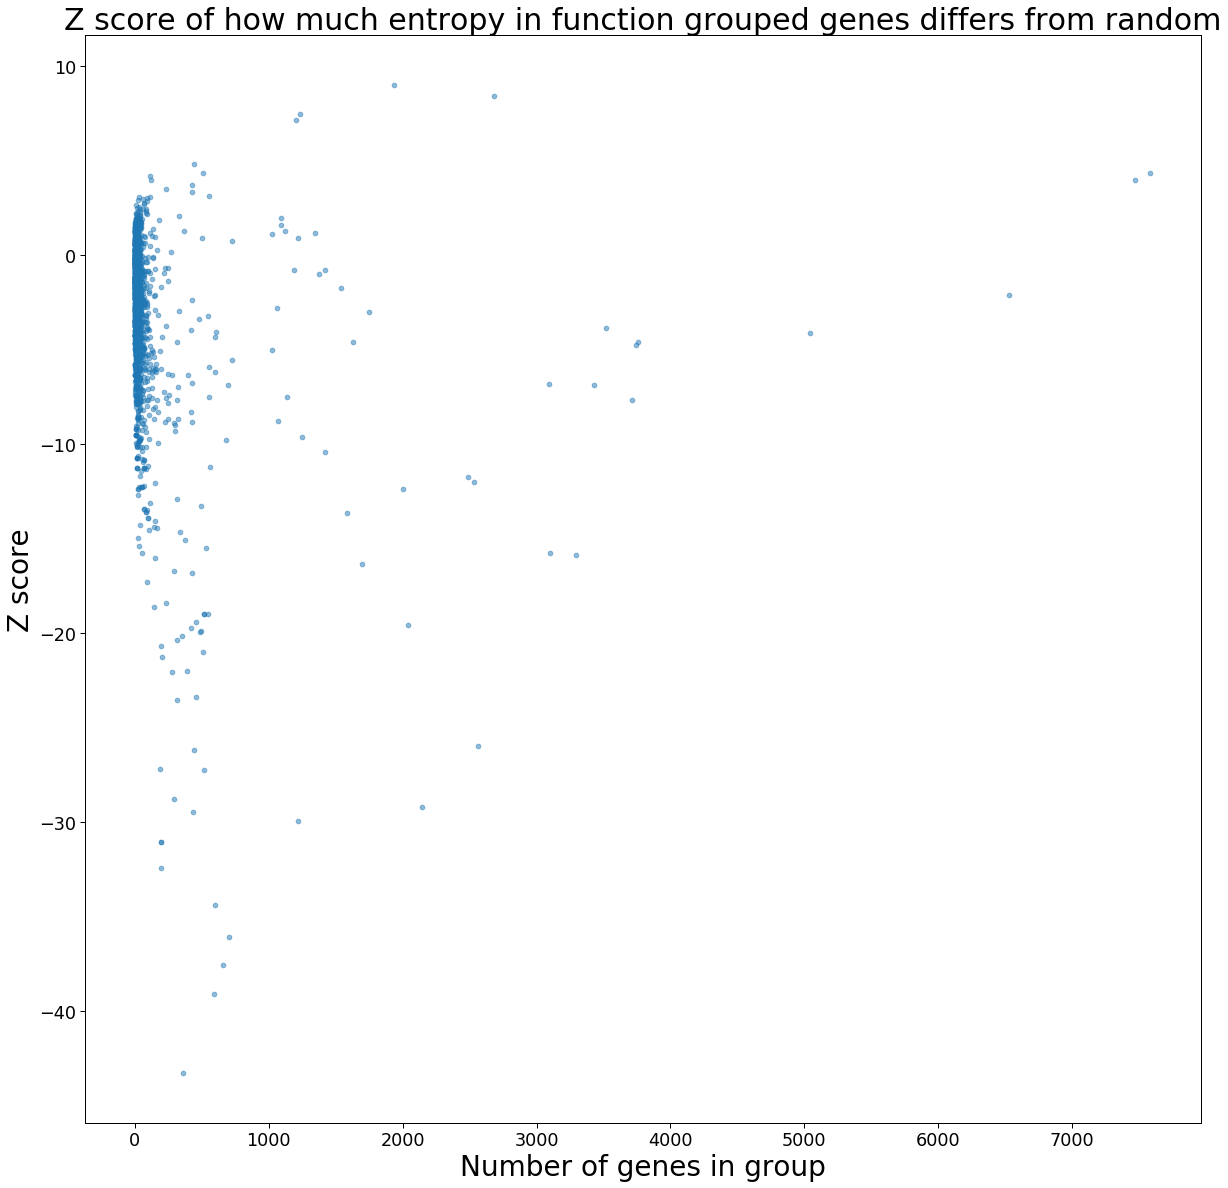

In [117]:
num_genes_list = [el[0] for el in num_genes_and_zscore_list]# if el[0] < 1000]
zscore_list = [el[1] for el in num_genes_and_zscore_list ]# if el[0] < 1000]
plt.xlabel("Number of genes in group", fontsize=28)
plt.ylabel("Z score", fontsize=28)
plt.title("Z score of how much entropy in function grouped genes differs from random", fontsize=30)
plt.scatter(num_genes_list, zscore_list, alpha = 0.5)

In [118]:
np.mean(zscore_list )

-2.907515413798978

(array([  1.,   1.,   2.,   1.,   3.,   4.,   4.,   2.,   9.,   9.,  13.,
         26.,  53., 118., 329., 874., 790., 129.,   6.,   4.]),
 array([-43.25775197, -40.64525505, -38.03275813, -35.42026121,
        -32.80776429, -30.19526737, -27.58277045, -24.97027352,
        -22.3577766 , -19.74527968, -17.13278276, -14.52028584,
        -11.90778892,  -9.29529199,  -6.68279507,  -4.07029815,
         -1.45780123,   1.15469569,   3.76719261,   6.37968953,
          8.99218646]),
 <a list of 20 Patch objects>)

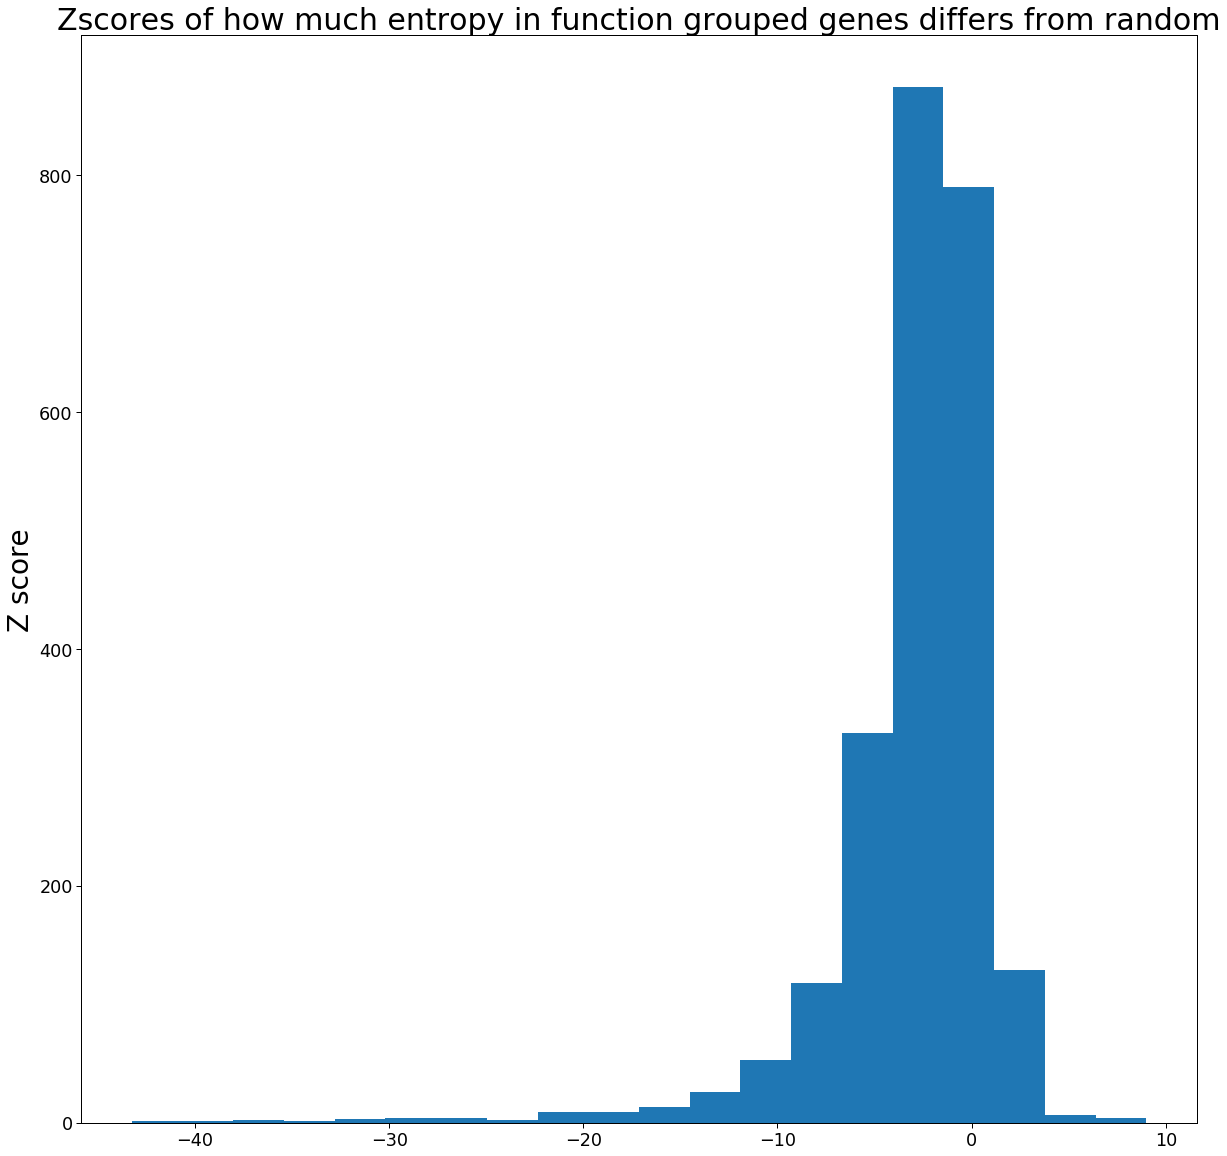

In [120]:
plt.ylabel("Z score", fontsize=28)
plt.title("Zscores of how much entropy in function grouped genes differs from random", fontsize=30)
plt.hist(zscore_list,bins=20 )